# Temperature validation: 



In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import pandas as pd
import xarray as xr

from scipy import signal
from scipy import stats
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

In [2]:
def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

def load_mpi_lm_regridded():
    mpi_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/MPI/'
    mpi_file = 'mpi_sic_sit_tas_20CRv2_850_1850_full.npz'

    mpi_lm = np.load(mpi_dir+mpi_file)

    mpi_truth_sic = mpi_lm['sic_mpi']
    mpi_truth_sit = mpi_lm['sit_mpi']
    mpi_truth_tas = mpi_lm['tas_mpi']
    mpi_truth_lat = mpi_lm['lat_mpi']
    mpi_truth_lon = mpi_lm['lon_mpi']
    
    return mpi_truth_tas, mpi_truth_sic, mpi_truth_sit, mpi_truth_lat, mpi_truth_lon

def find_ce_corr(VAR, REF, REF_TIME, VAR_TIME, START_TIME, END_TIME, detrend=False):
    """Finds the correlation coefficient and coefficient of efficiency between 
       REF and VAR between START_TIME and END_TIME.
       inputs: 
           VAR = test data (1D in time)
           REF = reference data (1D in time) 
           REF_time = reference data time (1D time)
           VAR_TIME = test data time (1D years)
           START_TIME = comparison start year to be included (float)
           END_TIME = last year included in comparison (float)
       
    """
    yr_range_var = np.where((VAR_TIME>=START_TIME)&(VAR_TIME<END_TIME+1))
    yr_range_ref = np.where((REF_TIME>=START_TIME)&(REF_TIME<END_TIME+1))
    
    if detrend is False: 
        ref = REF[yr_range_ref[0]]
        var = VAR[yr_range_var[0]]
    else: 
        ref = spy.detrend(REF[yr_range_ref])
        var = spy.detrend(VAR[yr_range_var])
        
    ce = coefficient_efficiency(ref,var)
    corr = np.corrcoef(ref,var)[0,1]
    var_ref = np.var(ref)
    var_var = np.var(var)
    
    return ce, corr,var_ref,var_var

def coefficient_efficiency(ref,test,valid=None):
    """
    ***Copied from LMR_utils.py 04/08/20***
    Compute the coefficient of efficiency for a test time series, 
    with respect to a reference time series.

    Inputs:
    test:  test array
    ref:   reference array, of same size as test
    valid: fraction of valid data required to calculate the statistic 

    Note: Assumes that the first dimension in test and ref arrays is time!!!

    Outputs:
    CE: CE statistic calculated following Nash & Sutcliffe (1970)
    """

    # check array dimensions
    dims_test = test.shape
    dims_ref  = ref.shape
    #print('dims_test: ', dims_test, ' dims_ref: ', dims_ref)

    if len(dims_ref) == 3:   # 3D: time + 2D spatial
        dims = dims_ref[1:3]
    elif len(dims_ref) == 2: # 2D: time + 1D spatial
        dims = dims_ref[1:2]
    elif len(dims_ref) == 1: # 0D: time series
        dims = 1
    else:
        print('In coefficient_efficiency(): Problem with input array dimension! Exiting...')
        SystemExit(1)

    CE = np.zeros(dims)

    # error
    error = test - ref

    # CE
    numer = np.nansum(np.power(error,2),axis=0)
    denom = np.nansum(np.power(ref-np.nanmean(ref,axis=0),2),axis=0)
    CE    = 1. - np.divide(numer,denom)

    if valid:
        nbok  = np.sum(np.isfinite(ref),axis=0)
        nball = float(dims_ref[0])
        ratio = np.divide(nbok,nball)
        indok  = np.where(ratio >= valid)
        indbad = np.where(ratio < valid)
        dim_indbad = len(indbad)
        testlist = [indbad[k].size for k in range(dim_indbad)]
        if not all(v == 0 for v in testlist):
            if isinstance(dims,(tuple,list)):
                CE[indbad] = np.nan
            else:
                CE = np.nan

    return CE

In [3]:
plt.rcParams['figure.dpi']=200

In [4]:
anom_start = 1961
anom_end = 1990

### Load Arctic2k: 

In [5]:
arctic2k_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/temp_recons/Arctic2k_v1.1.1/'
arctic2k_filename = 'Reconstruction_Arc2kv1.1.1.xlsx'

df = pd.read_excel(arctic2k_dir+arctic2k_filename)

In [6]:
df.head()

,Year AD,Temperature (deg C anomaly wrt 1961-1990),2 sigma unc. low,2 sigma unc. high,Unnamed: 4,Bin Center (AD),Temperature (deg C anomaly wrt 1961-1990).1,Unnamed: 7,Bin Center (AD).1,Temperature (deg C anomaly wrt 1961-1990).2
0,1,-0.667041,-1.720825,0.368022,NaN,5.0,-0.543636,NaN,50.0,-0.254158
1,2,-0.473002,-1.451590,0.476261,NaN,35.0,-0.132684,NaN,150.0,-0.238647
2,3,0.234856,-0.844589,1.372480,NaN,65.0,-0.177005,NaN,250.0,-0.283881
3,4,0.430979,-0.419973,1.277116,NaN,95.0,-0.282302,NaN,350.0,-0.324304
4,5,0.093220,-0.839945,0.976867,NaN,125.0,-0.022188,NaN,450.0,-0.128502


In [7]:
arctic2k_temp = df['Temperature (deg C anomaly wrt 1961-1990)'].values
arctic2k_2sig_low = df['2 sigma unc. low']
arctic2k_2sig_high = df['2 sigma unc. high']
arctic2k_years = df['Year AD']

### Load N-TREND: 

In [8]:
ntrend_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/temp_recons/'
ntrend_filename = 'ntrend2017grid.nc'

ntrend_ds = xr.open_dataset(ntrend_dir+ntrend_filename)

In [9]:
ntrend_ds.attrs['original reference']

"Anchukaitis, K.J., R. Wilson, K. Briffa, U. Buntgen, E.R. Cook, R.D. D'Arrigo, N. Davi, J. Esper, D. Frank, B. Gunnarson, G. Hegerl, S. Helama, S. Klesse, P.J. Krusic, H. Linderholm, V. Myglan, T. J. Osborn, Z. Peng, M. Rydval, L. Schneider, A. Schurer, G. Wiles and E. Zorita, Last millennium northern hemisphere summer temperatures from tree rings: Part II, spatially resolved reconstructions, Quaternary Science Reviews, 163, 1--22,doi: 10.1016/j.quascirev.2017.02.020, 2017"

In [10]:
min_lat=60
lat_weight = np.cos(np.deg2rad(ntrend_ds.latitude))

t_arcmn = (ntrend_ds.t_filtered*lat_weight).where(ntrend_ds.t_filtered['latitude']>=min_lat).sum(dim=['longitude','latitude'])
weight_sum = lat_weight.where(ntrend_ds.t_filtered['latitude']>=min_lat).sum(dim=['latitude'])*ntrend_ds.t_filtered.sizes['longitude']
ntrend_arcmn = t_arcmn/weight_sum

## Load reconstructions:

In [11]:
recon_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/data/'
recon_file_ccsm4 = 'Brennan_and_Hakim_2021_CCSM4_model_prior_reconstructions_nh.nc'
recon_file_mpi = 'Brennan_and_Hakim_2021_MPI_model_prior_reconstructions_nh.nc'

recon_data_ccsm4 = xr.open_dataset(recon_dir+recon_file_ccsm4)
recon_data_mpi = xr.open_dataset(recon_dir+recon_file_mpi)

In [12]:
amtas_ensmn_anom_ccsm4 = recon_data_ccsm4.arctic_tas_ensemble_mean_anomalies.values
amtas_ensmn_anom_mpi = recon_data_mpi.arctic_tas_ensemble_mean_anomalies.values

amtas_ensmn_anom_filt20_ccsm4 = recon_data_ccsm4.arctic_tas_ensemble_mean_anomalies_filtered.values
amtas_ensmn_anom_filt20_mpi = recon_data_mpi.arctic_tas_ensemble_mean_anomalies_filtered.values

amtas_ccsm4_97_5 = recon_data_ccsm4.arctic_tas_97_5_percentiles.values
amtas_ccsm4_2_5 = recon_data_ccsm4.arctic_tas_2_5_percentiles.values

amtas_mpi_97_5 = recon_data_mpi.arctic_tas_97_5_percentiles.values
amtas_mpi_2_5 = recon_data_mpi.arctic_tas_2_5_percentiles.values

recon_years = recon_data_mpi.time.values

In [13]:
Wn2 = 1.0/20
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)

amtas_mpi_low_filt20 = signal.filtfilt(b2,a2,amtas_mpi_2_5)
amtas_mpi_high_filt20 = signal.filtfilt(b2,a2,amtas_mpi_97_5)

amtas_ccsm4_low_filt20 = signal.filtfilt(b2,a2,amtas_ccsm4_2_5)
amtas_ccsm4_high_filt20 = signal.filtfilt(b2,a2,amtas_ccsm4_97_5)

arctic2k_filt20 = signal.filtfilt(b2,a2,arctic2k_temp)
arctic2k_low_filt20 = signal.filtfilt(b2,a2,arctic2k_2sig_low)
arctic2k_high_filt20 = signal.filtfilt(b2,a2,arctic2k_2sig_high)

ntrend_filt20 = signal.filtfilt(b2,a2,ntrend_arcmn)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


### Move anomalies to be about 1961-1990: 

In [14]:
amtas_ensmn_mpi_filt20_61_90 = amtas_ensmn_anom_filt20_mpi - np.nanmean(amtas_ensmn_anom_filt20_mpi[1961:1991])
amtas_ensmn_mpi_filt20_low_61_90 = amtas_mpi_low_filt20 - np.nanmean(amtas_ensmn_anom_filt20_mpi[1961:1991])
amtas_ensmn_mpi_filt20_high_61_90 = amtas_mpi_high_filt20 - np.nanmean(amtas_ensmn_anom_filt20_mpi[1961:1991])

amtas_ensmn_ccsm4_filt20_61_90 = amtas_ensmn_anom_filt20_ccsm4 - np.nanmean(amtas_ensmn_anom_filt20_ccsm4[1961:1991])
amtas_ensmn_ccsm4_filt20_low_61_90 = amtas_ccsm4_low_filt20 - np.nanmean(amtas_ensmn_anom_filt20_ccsm4[1961:1991])
amtas_ensmn_ccsm4_filt20_high_61_90 = amtas_ccsm4_high_filt20 - np.nanmean(amtas_ensmn_anom_filt20_ccsm4[1961:1991])

amtas_ensmn_anom_mpi_61_90 = amtas_ensmn_anom_mpi-np.nanmean(amtas_ensmn_anom_mpi[1961:1991])
amtas_ensmn_anom_ccsm4_61_90 = amtas_ensmn_anom_ccsm4-np.nanmean(amtas_ensmn_anom_ccsm4[1961:1991])

## Calculate skill metrics for Table S1: 

In [15]:
[ce_amtas_arctic2k_mpi_filt,
 corr_amtas_arctic2k_mpi_filt,_,_] = find_ce_corr(amtas_ensmn_mpi_filt20_61_90, arctic2k_filt20,
                                                  arctic2k_years,np.array(recon_years),0,2000)

[ce_amtas_arctic2k_mpi,
 corr_amtas_arctic2k_mpi,_,_] = find_ce_corr(amtas_ensmn_anom_mpi_61_90,arctic2k_temp,arctic2k_years,
                                             np.array(recon_years),0,2000)

[ce_amtas_arctic2k_ccsm4_filt,
 corr_amtas_arctic2k_ccsm4_filt,_,_] = find_ce_corr(amtas_ensmn_ccsm4_filt20_61_90, arctic2k_filt20,
                                                    arctic2k_years,np.array(recon_years),0,2000)

[ce_amtas_arctic2k_ccsm4,
 corr_amtas_arctic2k_ccsm4,_,_] = find_ce_corr(amtas_ensmn_anom_ccsm4_61_90, arctic2k_temp,arctic2k_years,
                                               np.array(recon_years),0,2000)

[ce_amtas_mpi_ccsm4,
 corr_amtas_mpi_ccsm4,_,_] = find_ce_corr(amtas_ensmn_anom_ccsm4_61_90, amtas_ensmn_anom_mpi,
                                          np.array(recon_years),np.array(recon_years),0,2000)

[ce_amtas_mpi_ccsm4_filt,
 corr_amtas_mpi_ccsm4_filt,_,_] = find_ce_corr(amtas_ensmn_mpi_filt20_61_90, amtas_ensmn_ccsm4_filt20_61_90,
                                               np.array(recon_years),np.array(recon_years),0,2000)

In [16]:
[ce_amtas_arctic2k_mpi_filt,
 corr_amtas_arctic2k_mpi_filt,_,_] = find_ce_corr(amtas_ensmn_mpi_filt20_61_90, arctic2k_filt20,
                                                  arctic2k_years,np.array(recon_years),0,2000)

[ce_amtas_arctic2k_mpi,
 corr_amtas_arctic2k_mpi,_,_] = find_ce_corr(amtas_ensmn_anom_mpi_61_90, arctic2k_temp,
                                             arctic2k_years,np.array(recon_years),0,2000)

[ce_amtas_arctic2k_ccsm4_filt,
 corr_amtas_arctic2k_ccsm4_filt,_,_] = find_ce_corr(amtas_ensmn_ccsm4_filt20_61_90, arctic2k_filt20,
                                                    arctic2k_years,np.array(recon_years),0,2000)

[ce_amtas_arctic2k_ccsm4,
 corr_amtas_arctic2k_ccsm4,_,_] = find_ce_corr(amtas_ensmn_anom_ccsm4_61_90, arctic2k_temp,
                                               arctic2k_years,np.array(recon_years),0,2000)

In [17]:
print("R^2: Arctic2k v MPI          = "+ str(np.round(corr_amtas_arctic2k_mpi**2,2)))
print("CE:  Arctic2k v MPI          = "+ str(np.round(ce_amtas_arctic2k_mpi,2))+'\n')
print("R^2: Arctic2k v MPI filtered = "+ str(np.round(corr_amtas_arctic2k_mpi_filt**2,2)))
print("CE:  Arctic2k v MPI filtered = "+ str(np.round(ce_amtas_arctic2k_mpi_filt,2))+'\n')

print("R^2: Arctic2k v CCSM4          = "+ str(np.round(corr_amtas_arctic2k_ccsm4**2,2)))
print("CE:  Arctic2k v CCSM4          = "+ str(np.round(ce_amtas_arctic2k_ccsm4,2))+'\n')
print("R^2: Arctic2k v CCSM4 filtered = "+ str(np.round(corr_amtas_arctic2k_ccsm4_filt**2,2)))
print("CE:  Arctic2k v CCSM4 filtered = "+ str(np.round(ce_amtas_arctic2k_ccsm4_filt,2))+'\n')

print("R^2: MPI v CCSM4          = "+ str(np.round(corr_amtas_mpi_ccsm4**2,2)))
print("CE:  MPI v CCSM4          = "+ str(np.round(ce_amtas_mpi_ccsm4,2))+'\n')
print("R^2: filtered MPI v CCSM4 filtered = "+ str(np.round(corr_amtas_mpi_ccsm4_filt**2,2)))
print("CE:  filtered MPI v CCSM4 filtered = "+ str(np.round(ce_amtas_mpi_ccsm4_filt,2))+'\n')

R^2: Arctic2k v MPI          = 0.31
CE:  Arctic2k v MPI          = 0.18

R^2: Arctic2k v MPI filtered = 0.67
CE:  Arctic2k v MPI filtered = 0.46

R^2: Arctic2k v CCSM4          = 0.27
CE:  Arctic2k v CCSM4          = 0.21

R^2: Arctic2k v CCSM4 filtered = 0.61
CE:  Arctic2k v CCSM4 filtered = 0.56

R^2: MPI v CCSM4          = 0.94
CE:  MPI v CCSM4          = 0.39

R^2: filtered MPI v CCSM4 filtered = 0.96
CE:  filtered MPI v CCSM4 filtered = 0.88



In [18]:
[ce_amtas_ntrend_ccsm4_filt,
 corr_amtas_ntrend_ccsm4_filt,_,_] = find_ce_corr(amtas_ensmn_ccsm4_filt20_61_90, ntrend_filt20,
                                                  ntrend_ds.time, np.array(recon_years),750,1999)

[ce_amtas_ntrend_mpi_filt,
 corr_amtas_ntrend_mpi_filt,_,_] = find_ce_corr(amtas_ensmn_mpi_filt20_61_90, ntrend_filt20,
                                                ntrend_ds.time,np.array(recon_years),750,1999)

[ce_amtas_ntrend_mpi,
 corr_amtas_ntrend_mpi,_,_] = find_ce_corr(amtas_ensmn_anom_mpi_61_90, ntrend_arcmn,
                                           ntrend_ds.time,np.array(recon_years),750,1999)

[ce_amtas_ntrend_ccsm4,
 corr_amtas_ntrend_ccsm4,_,_] = find_ce_corr(amtas_ensmn_anom_ccsm4_61_90, ntrend_arcmn,
                                             ntrend_ds.time,np.array(recon_years),750,1999)

print("R^2: NTREND v CCSM4 filtered = "+ str(np.round(corr_amtas_ntrend_ccsm4_filt**2,2)))
print("R^2: NTREND v MPI filtered = "+ str(np.round(corr_amtas_ntrend_mpi_filt**2,2))+'\n')

print("CE:  NTREND v CCSM4 filtered = "+ str(np.round(ce_amtas_ntrend_ccsm4_filt,2)))
print("CE:  NTREND v MPI filtered = "+ str(np.round(ce_amtas_ntrend_mpi_filt,2))+'\n')

print("R^2: NTREND v CCSM4 = "+ str(np.round(corr_amtas_ntrend_ccsm4**2,2)))
print("R^2: NTREND v MPI   = "+ str(np.round(corr_amtas_ntrend_mpi**2,2))+'\n')

print("CE:  NTREND v CCSM4 = "+ str(np.round(ce_amtas_ntrend_ccsm4,2)))
print("CE:  NTREND v MPI   = "+ str(np.round(ce_amtas_ntrend_mpi,2))+'\n')

R^2: NTREND v CCSM4 filtered = 0.79
R^2: NTREND v MPI filtered = 0.81

CE:  NTREND v CCSM4 filtered = -4.02
CE:  NTREND v MPI filtered = -2.23

R^2: NTREND v CCSM4 = 0.5
R^2: NTREND v MPI   = 0.55

CE:  NTREND v CCSM4 = -1.49
CE:  NTREND v MPI   = -0.55



## Figure S3: 

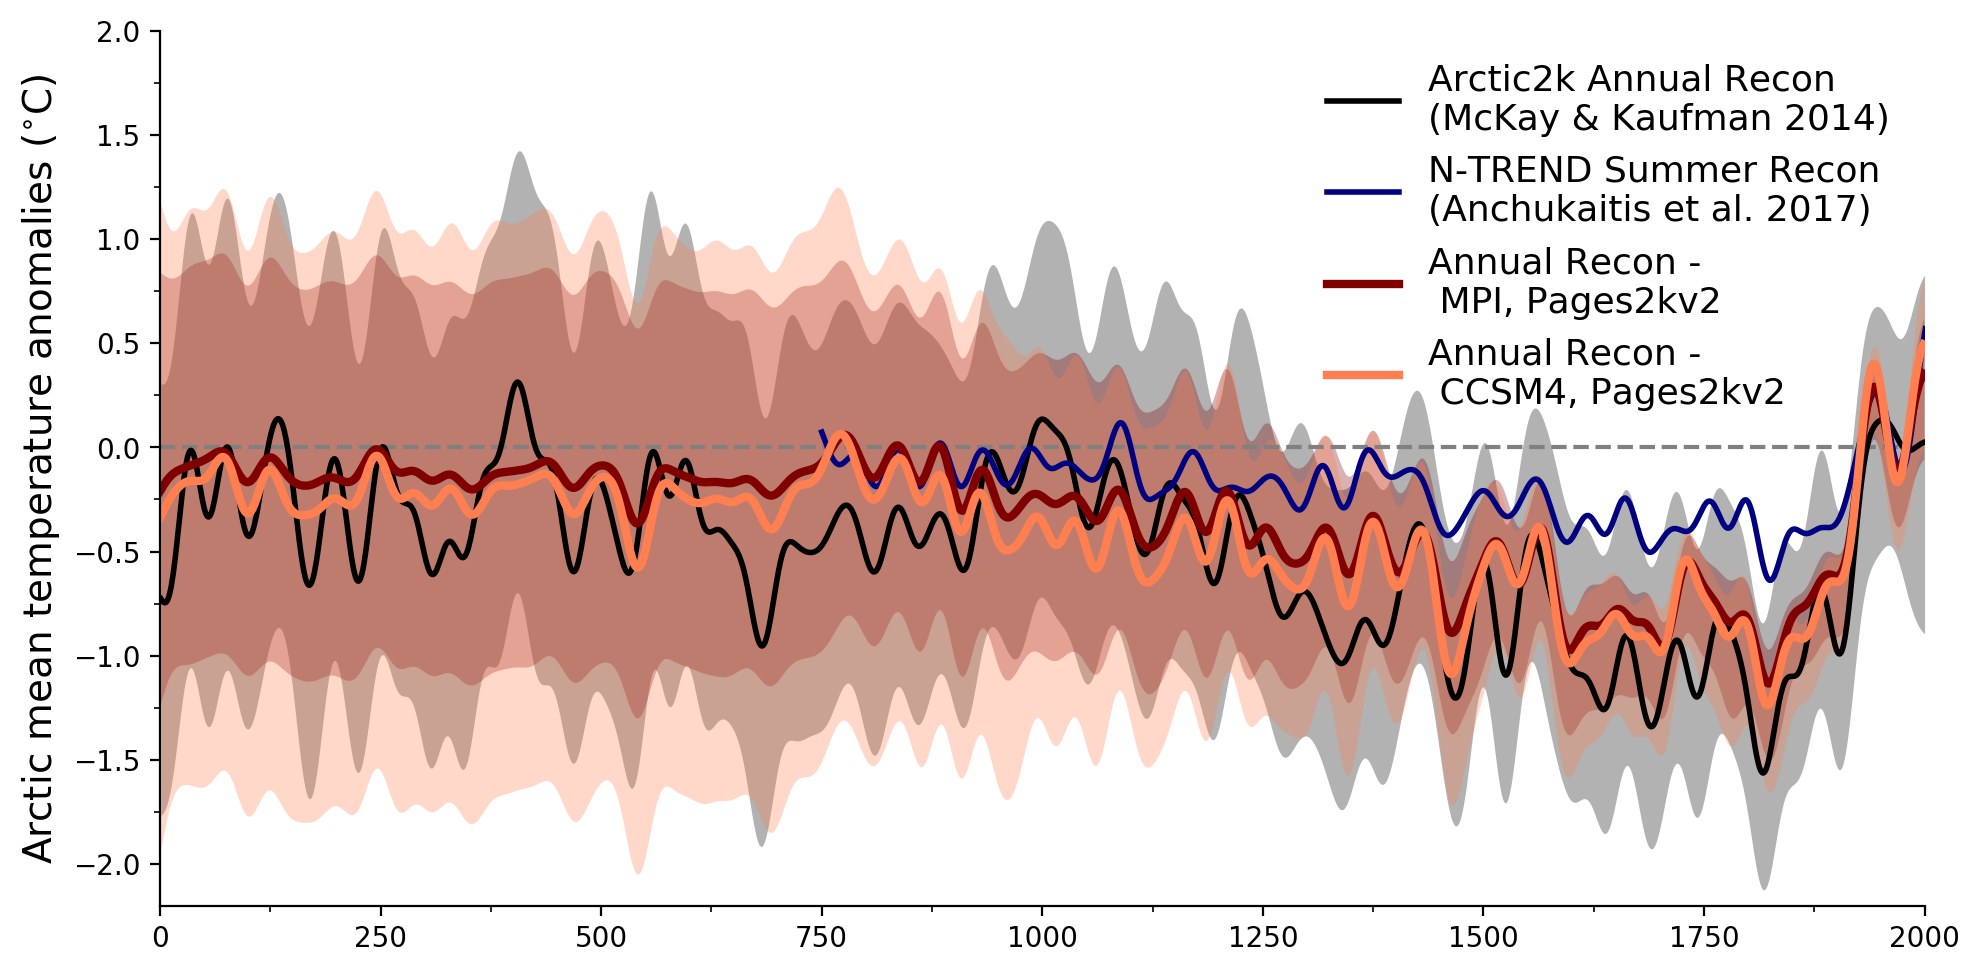

In [19]:
fig, ax_recon = plt.subplots(1, figsize=(10,5))

ax_recon.axhline(0,linestyle='--',color='grey')


ax_recon.fill_between(arctic2k_years,arctic2k_low_filt20,arctic2k_high_filt20,
                      color='k',lw=0.01,alpha=0.3)
ax_recon.fill_between(recon_years,amtas_ensmn_mpi_filt20_low_61_90,amtas_ensmn_mpi_filt20_high_61_90,
                       color='maroon',lw=0.01,alpha=0.3)
ax_recon.fill_between(recon_years,amtas_ensmn_ccsm4_filt20_low_61_90,amtas_ensmn_ccsm4_filt20_high_61_90,
                       color='coral',lw=0.01,alpha=0.3)

ax_recon.plot(arctic2k_years,arctic2k_filt20, color='k',linewidth=2,
              label='Arctic2k Annual Recon \n(McKay & Kaufman 2014)')
ax_recon.plot(ntrend_ds.time,ntrend_filt20, color='navy',linewidth=2,
              label='N-TREND Summer Recon \n(Anchukaitis et al. 2017)')
ax_recon.plot(recon_years,amtas_ensmn_mpi_filt20_61_90,color='maroon',
         label='Annual Recon - \n MPI, Pages2kv2',linewidth=3)
ax_recon.plot(recon_years,amtas_ensmn_ccsm4_filt20_61_90,color='coral',
         label='Annual Recon - \n CCSM4, Pages2kv2',linewidth=3)


ax_recon.set_ylabel('Arctic mean temperature anomalies ($^{\circ}$C)',fontsize=14)
ax_recon.legend(fontsize=13,loc='upper right',frameon=False)

ax_recon.set_xlim(0,2000)
ax_recon.set_ylim(-2.2,2)

ax_recon.spines['top'].set_visible(False)
ax_recon.spines['right'].set_visible(False)

ax_recon.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_recon.xaxis.set_minor_locator(MultipleLocator(125))

plt.subplots_adjust(wspace=0, hspace=0.05)

plt.tight_layout()

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Arctic_tas_comparison_mpi_ccms4_ntrend_arctic2k.png'
#plt.savefig(savedir+savename)